# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [10]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:
!pip install protobuf==3.20.0


In [11]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [12]:
import os
print(os.getcwd())
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

/root/ImageClassificationAWSSageMakerPytorch
RoleArn: arn:aws:iam::546248296374:role/service-role/AmazonSageMaker-ExecutionRole-20240419T174807


In [32]:
#TODO: Fetch and upload the data to AWS S3

# !aws s3 cp /root/ImageClassificationAWSSageMakerPytorch/food_10_classes_10_percentimage.zip s3://fooddataset10class
# !aws s3 sync /root/ImageClassificationAWSSageMakerPytorch/food_10_classes_10_percent/train/ s3://fooddataset10class/train
# !aws s3 sync /root/ImageClassificationAWSSageMakerPytorch/food_10_classes_10_percent/test/ s3://fooddataset10class/test
# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !aws s3 cp s3://fooddataset10class/food_10_classes_10_percentimage.zip .
# !unzip food_10_classes_10_percentimage.zip

In [13]:
BUCKET = 'fooddataset10class'

os.environ['SM_CHANNEL_TRAINING']=f's3://{BUCKET}/'
os.environ['SM_MODEL_DIR']=f's3://{BUCKET}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{BUCKET}/output/'
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [14]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [28]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs":CategoricalParameter([10, 15, 20])
}

In [29]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

In [30]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [31]:
# TODO: Fit your HP Tuner
tuner.fit({"training":f"s3://{BUCKET}/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [32]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-04-21 01:19:24 Starting - Found matching resource for reuse
2024-04-21 01:19:24 Downloading - Downloading the training image
2024-04-21 01:19:24 Training - Training image download completed. Training in progress.
2024-04-21 01:19:24 Uploading - Uploading generated training model
2024-04-21 01:19:24 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'epochs': '"15"',
 'lr': '0.00274723454500732',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-04-21-00-40-34-983"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-546248296374/pytorch-training-2024-04-21-00-40-34-983/source/sourcedir.tar.gz"'}

In [33]:
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": int(best_estimator.hyperparameters()['epochs'].replace('"', ''))
                  }
hyperparameters

{'batch-size': 128, 'lr': '0.00274723454500732', 'epochs': 15}

In [37]:
job_name = best_estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=best_estimator.latest_training_job.name)
description

{'TrainingJobName': 'pytorch-training-240421-0040-004-10f49e5e',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:546248296374:training-job/pytorch-training-240421-0040-004-10f49e5e',
 'TuningJobArn': 'arn:aws:sagemaker:us-east-1:546248296374:hyper-parameter-tuning-job/pytorch-training-240421-0040',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-546248296374/pytorch-training-240421-0040-004-10f49e5e/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'_tuning_objective_metric': 'average test loss',
  'batch-size': '"128"',
  'epochs': '"15"',
  'lr': '0.00274723454500732',
  'sagemaker_container_log_level': '20',
  'sagemaker_estimator_class_name': '"PyTorch"',
  'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
  'sagemaker_job_name': '"pytorch-training-2024-04-21-00-40-34-983"',
  'sagemaker_program': '"hpo.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagema

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [42]:
# TODO: Set up debugging and profiling rules and hooks

from sagemaker.debugger import Rule, DebuggerHookConfig, ProfilerRule, ProfilerConfig, FrameworkProfile, rule_configs, CollectionConfig
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)


collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "10"})]
hook_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

# hook_config = DebuggerHookConfig(
#     hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
# )


# we got this from hpo.py training jobs above
hyperparameters={'batch-size': 128, 'lr': '0.00274723454500732', 'epochs': 15}

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [43]:
# TODO: Create and fit an estimator
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    base_job_name="FOOD-CLASSIFIER-MAIN",
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.c4.xlarge",
    rules=rules,
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=hook_config
)



In [44]:
# fitting model
estimator.fit({"training":f"s3://{BUCKET}/"})

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2024-04-22 00:32:13 Starting - Starting the training job...
2024-04-22 00:32:40 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-04-22 00:33:08 Downloading - Downloading input data......
2024-04-22 00:34:07 Downloading - Downloading the training image...
2024-04-22 00:34:40 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-04-22 00:34:40,608 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-04-22 00:34:40,611 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-04-22 00:34:40,620 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024

In [45]:
import pprint
pp = pprint.PrettyPrinter(depth=4)


In [46]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
pp.pprint(description)

{'AlgorithmSpecification': {'EnableSageMakerMetricsTimeSeries': True,
                            'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8-cpu-py36',
                            'TrainingInputMode': 'File'},
 'BillableTimeInSeconds': 900,
 'CreationTime': datetime.datetime(2024, 4, 22, 0, 32, 13, 670000, tzinfo=tzlocal()),
 'DebugHookConfig': {'CollectionConfigurations': [{'CollectionName': 'losses',
                                                   'CollectionParameters': {'save_interval': '500'}},
                                                  {'CollectionName': 'relu_input',
                                                   'CollectionParameters': {'include_regex': '.*relu_input',
                                                                            'save_interval': '500'}},
                                                  {'CollectionName': 'gradients',
                                                   'CollectionParameters': 

num_steps**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [47]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
# trial=create_trial('s3://sagemaker-us-east-1-546248296374/FOOD-CLASSIFIER-MAIN-2024-04-21-23-21-29-358/debug-output')

[2024-04-22 00:48:54.258 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:298 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-546248296374/FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/debug-output


In [48]:
trial.tensor_names()

[2024-04-22 00:48:56.654 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:298 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-04-22 00:48:57.674 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:298 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'gradient/ResNet_fc.4.bias',
 'gradient/ResNet_fc.4.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [54]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

9

In [49]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")
    
    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


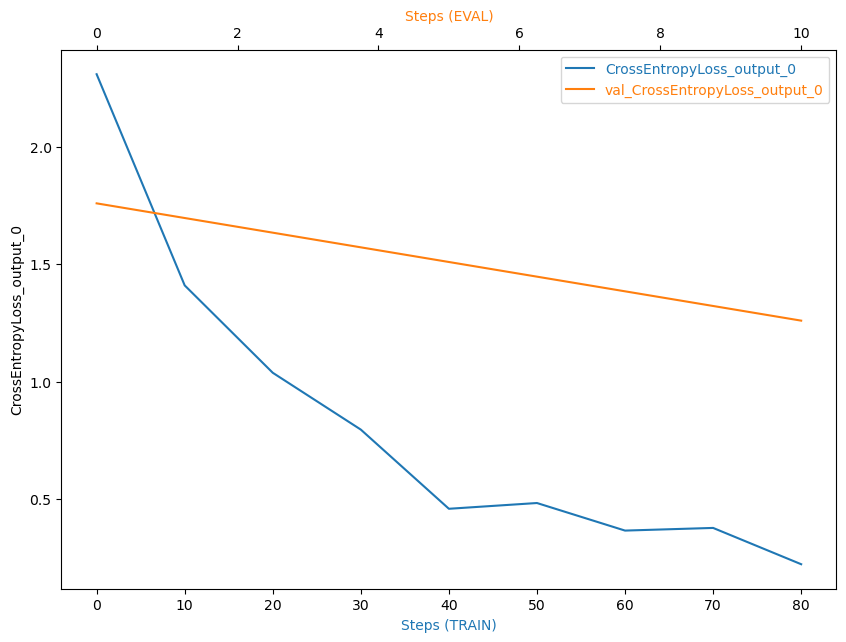

In [51]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [55]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://sagemaker-us-east-1-546248296374/FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output'

In [57]:
! aws s3 ls {rule_output_path} --recursive

2024-04-22 00:48:14     375593 FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-04-22 00:48:13     223524 FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-04-22 00:48:08        192 FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-04-22 00:48:08        200 FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-04-22 00:48:08       1968 FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-04-22 00:48:08        127 FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-04-22 00:48:08        199 FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport

In [58]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-546248296374/FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-546248296374/FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-546248296374/FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-546248296374/FOOD-CLASSIFIER-MAIN-2024-04-22-00-32-12-669/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-546248296374/FOOD-CLASSIF

In [63]:
import os



profiler_report_names=[]

for rule in estimator.latest_training_job.rule_job_summary():
    if "Profiler" in rule["RuleConfigurationName"]:
        profiler_report_names.append(rule["RuleConfigurationName"])
profiler_report_names

['ProfilerReport']

In [64]:


import IPython

IPython.display.HTML(filename=profiler_report_names[0] + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()